In [40]:
import pandas as pd
import numpy as np
import warnings

from mplsoccer import Pitch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# Get data

In [41]:
data = pd.read_csv("summary.csv")
data.head()

,shortName,role,xD_per_90,danger_passes_per_90
0,K. De Bruyne,Midfielder,0.614987,5.043783
1,J. Grealish,Forward,0.477864,5.633588
2,M. Kovačić,Midfielder,0.474472,3.848858
3,M. Ødegaard,Midfielder,0.473998,4.090909
4,T. Alexander-Arnold,Defender,0.463308,4.653740


In [42]:
data = data[(data["xD_per_90"] > 0) & (data["danger_passes_per_90"] > 0)]

In [43]:
data.role.value_counts()

role
Defender      132
Midfielder    121
Forward        95
Goalkeeper     31
Name: count, dtype: int64

In [44]:
# Colors
background_color = "#f2f4ee"
dark_color = "#053225"
keeper_color = "#226CE0"
defender_color = "#E57A44"
midfielder_color = "#388697"
forward_color = "#B91372"

role_colors = {
    'Goalkeeper': keeper_color,
    'Defender': defender_color,
    'Midfielder': midfielder_color,
    'Forward': forward_color
}

In [45]:
# Font
font = 'Futura'

# Density plots per role

<Axes: xlabel='xD_per_90', ylabel='Density'>

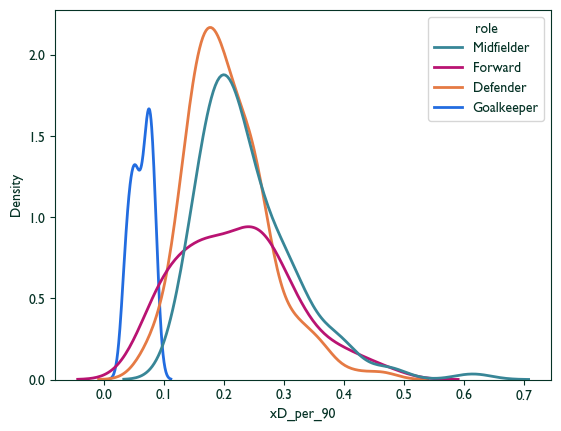

In [46]:
sns.kdeplot(data=data, x='xD_per_90', hue='role', palette=role_colors, linewidth=2)

<Axes: xlabel='danger_passes_per_90', ylabel='Density'>

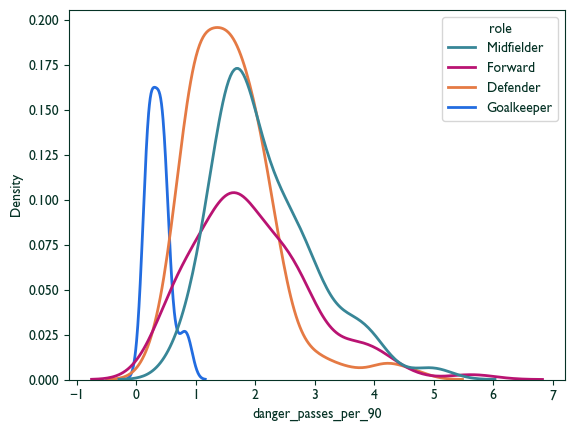

In [47]:
sns.kdeplot(data=data, x='danger_passes_per_90', hue='role', palette=role_colors, linewidth=2)

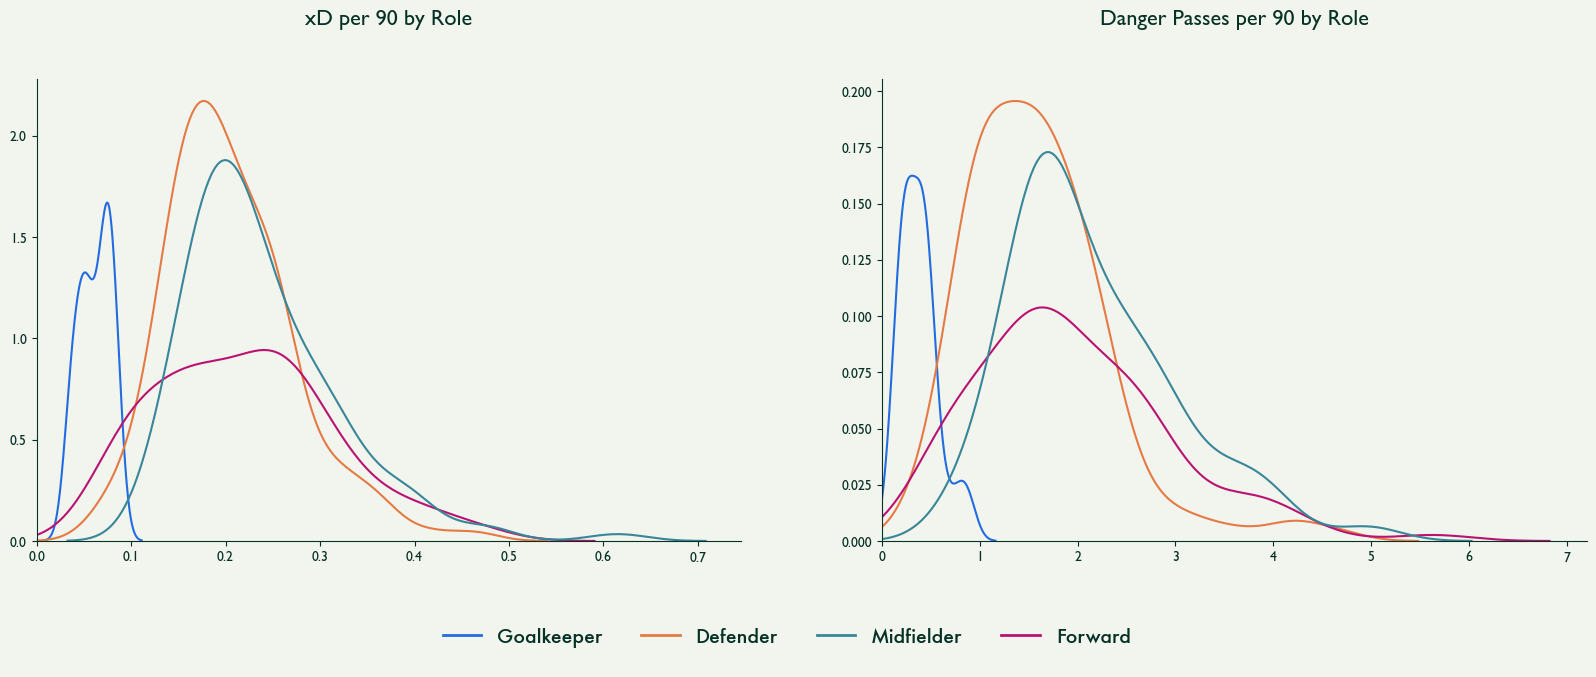

In [48]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
fig.set_facecolor(background_color)
plt.rcParams['font.family'] = font
plt.rcParams.update({
    'text.color': dark_color,
    'axes.labelcolor': dark_color,
    'axes.edgecolor': dark_color,
    'xtick.color': dark_color,
    'ytick.color': dark_color,
    'grid.color': dark_color,
})

# Set background color and styling for both subplots
for ax in [ax1, ax2]:
    ax.set_facecolor(background_color)
    ax.tick_params(colors=dark_color)
    ax.spines['bottom'].set_color(dark_color)
    ax.spines['top'].set_color(dark_color)
    ax.spines['left'].set_color(dark_color)
    ax.spines['right'].set_color(dark_color)

# First KDE plot
sns.kdeplot(data=data, x='xD_per_90', hue='role', palette=role_colors, ax=ax1, legend=False)
ax1.set_title('xD per 90 by Role', color=dark_color, fontsize=16, y=1.1)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xlim(left=0)

# Second KDE plot
sns.kdeplot(data=data, x='danger_passes_per_90', hue='role', palette=role_colors, ax=ax2, legend=False)
ax2.set_title('Danger Passes per 90 by Role', color=dark_color, fontsize=16, y=1.1)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xlim(left=0)

# Remove spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Custom legend
legend_ax = fig.add_axes([0.15, -0.1, 0.7, 0.1])  # Smaller axes below for legend
legend_ax.axis('off')  # Hide the axes

# Create legend handles and labels
legend_handles = [plt.Line2D([0], [0], color=role_colors[role], lw=2) for role in role_colors]
legend_labels = list(role_colors.keys())
legend_ax.legend(legend_handles, legend_labels, loc='center', ncol=len(role_colors), frameon=False, fontsize=14)

# Adjust layout and margins
plt.savefig('distribution_of_metrics_by_role.png', 
            bbox_inches='tight',
            pad_inches=0.5,  # Adjust this value to control the padding
            facecolor=background_color,
            dpi=300)

plt.show()

# xD per 90 v Danger passes per 90

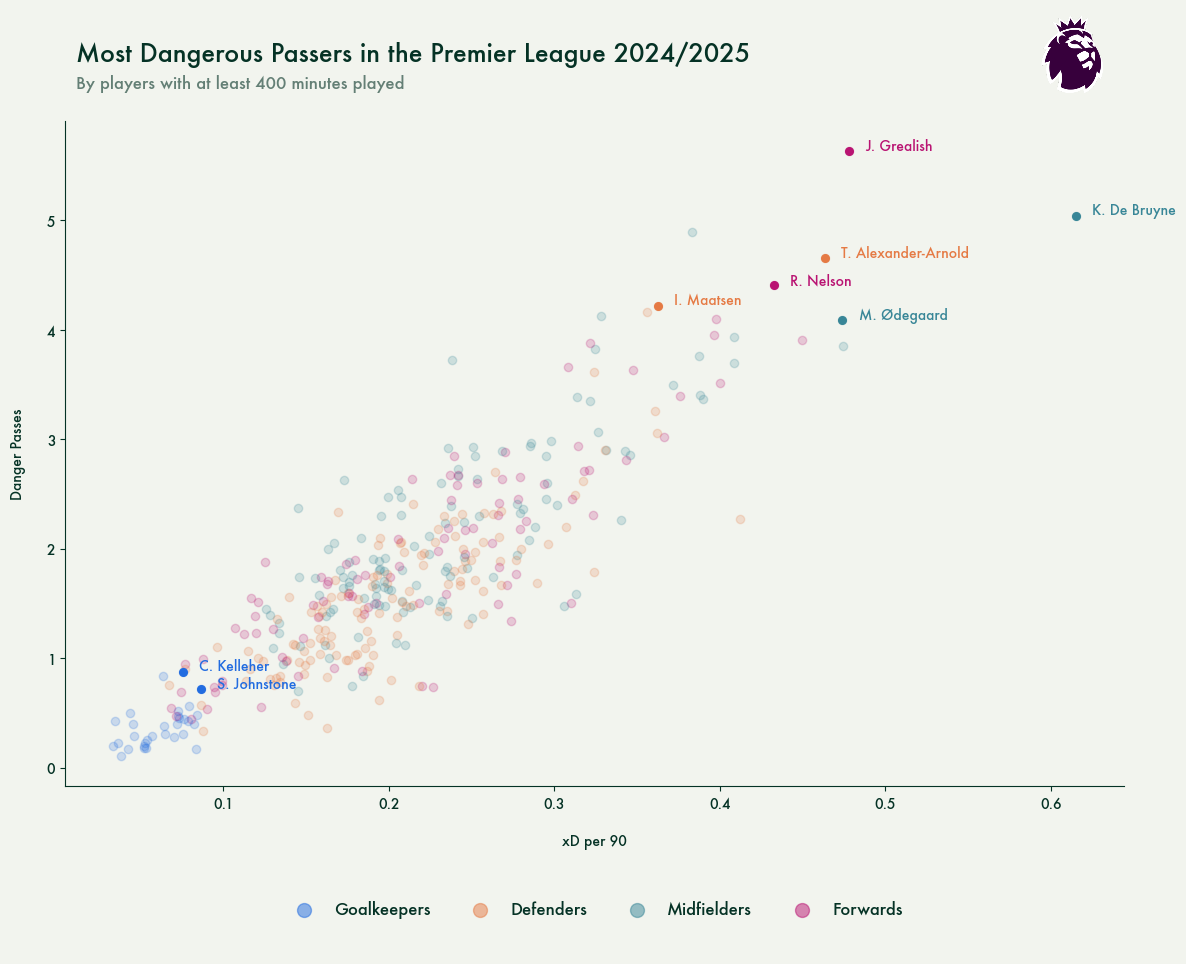

In [49]:
# Init plot
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[0.1, 0.9])

fig.set_facecolor(background_color)

# Top axis for title and logo
title_ax = fig.add_subplot(gs[0])
title_ax.axis('off')

# Main plot axis
ax = fig.add_subplot(gs[1])
ax.set_facecolor(background_color)

plt.rcParams['font.family'] = font
plt.rcParams.update({
    'text.color': dark_color,
    'axes.labelcolor': dark_color,
    'axes.edgecolor': dark_color,
    'xtick.color': dark_color,
    'ytick.color': dark_color,
    'grid.color': dark_color,
})

# Title and subtitle in title_ax
title_ax.text(0.01, 0.7, 'Most Dangerous Passers in the Premier League 2024/2025', 
              fontweight='bold', fontsize=18, ha='left', va='center')
title_ax.text(0.01, 0.3, 'By players with at least 400 minutes played', 
              fontsize=12, color=dark_color, alpha=0.6, ha='left', va='center')

# Add PL logo to title_ax
logo = mpimg.imread('pl-logo.png')
imagebox = OffsetImage(logo, zoom=0.25)
ab = AnnotationBbox(imagebox, (0.98, 0.7), xycoords='axes fraction', box_alignment=(1, 0.5), frameon=False)
title_ax.add_artist(ab)

# Set axis labels
ax.set_xlabel('xD per 90', labelpad=15)
ax.set_ylabel('Danger Passes', labelpad=15)

# First normalize both metrics for each role
for role in data['role'].unique():
    role_data = data[data['role'] == role]
    
    # Normalize xD per 90
    data.loc[data['role'] == role, 'xD_normalized'] = (role_data['xD_per_90'] - role_data['xD_per_90'].min()) / (role_data['xD_per_90'].max() - role_data['xD_per_90'].min())
    
    # Normalize danger passes per 90
    data.loc[data['role'] == role, 'danger_passes_normalized'] = (role_data['danger_passes_per_90'] - role_data['danger_passes_per_90'].min()) / (role_data['danger_passes_per_90'].max() - role_data['danger_passes_per_90'].min())

# Create combined danger score
data['danger_score'] = data['xD_normalized'] + data['danger_passes_normalized']

# Get top 3 most dangerous players for each role
top_players = data.groupby('role').apply(lambda x: x.nlargest(2, 'danger_score')).reset_index(drop=True)

# Plot data
for i, row in data.iterrows():
    color = role_colors[row['role']]
    ax.scatter(row['xD_per_90'], row['danger_passes_per_90'], color=color, alpha=.2)

# Add labels for top players
for i, row in top_players.iterrows():
    color = role_colors[row['role']]
    ax.scatter(row['xD_per_90'], row['danger_passes_per_90'], color=color, alpha=1, s=30)
    ax.text(row['xD_per_90'] + 0.01, row['danger_passes_per_90'] + 0.01, 
             row['shortName'], 
             color=color, 
             fontsize=10, 
             fontweight='bold')

# Custom legend
legend_ax = fig.add_axes([0.15, -0.1, 0.7, 0.1])  # Smaller axes below for legend
legend_ax.axis('off')  # Hide the axes

# Create legend handles and labels using scatter plots
legend_handles = [ax.scatter([], [], color=role_colors[role], alpha=.5, s=100) for role in role_colors]
legend_labels = ["Goalkeepers", "Defenders", "Midfielders", "Forwards"]
legend_ax.legend(legend_handles, legend_labels, loc='center', ncol=len(role_colors), frameon=False, fontsize=12)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout and margins
plt.savefig('dangerous-passes-per-90-vs-xd-per-90.png', 
            bbox_inches='tight',
            pad_inches=0.5,
            facecolor=background_color,
            dpi=300)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

--------------------------------
Top 10 xD_per_90 for Goalkeeper
--------------------------------
--------------------------------
Top 10 danger_passes_per_90 for Goalkeeper
--------------------------------
--------------------------------
Top 10 xD_per_90 for Defender
--------------------------------
--------------------------------
Top 10 danger_passes_per_90 for Defender
--------------------------------
--------------------------------
Top 10 xD_per_90 for Midfielder
--------------------------------
--------------------------------
Top 10 danger_passes_per_90 for Midfielder
--------------------------------
--------------------------------
Top 10 xD_per_90 for Forward
--------------------------------
--------------------------------
Top 10 danger_passes_per_90 for Forward
--------------------------------


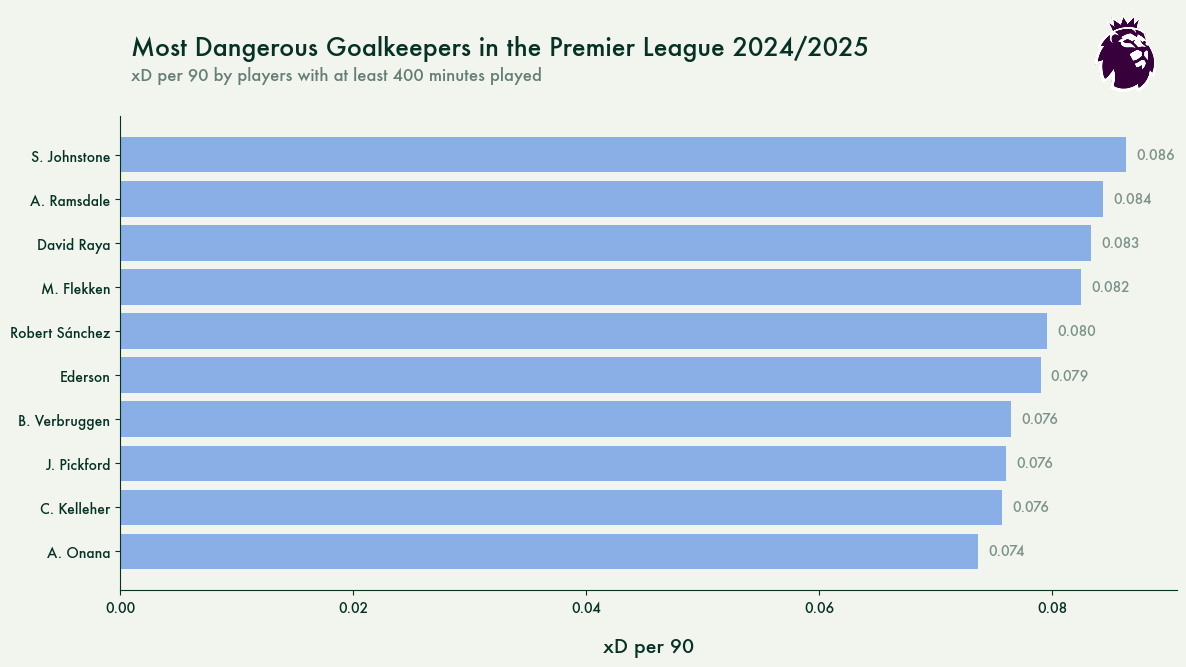

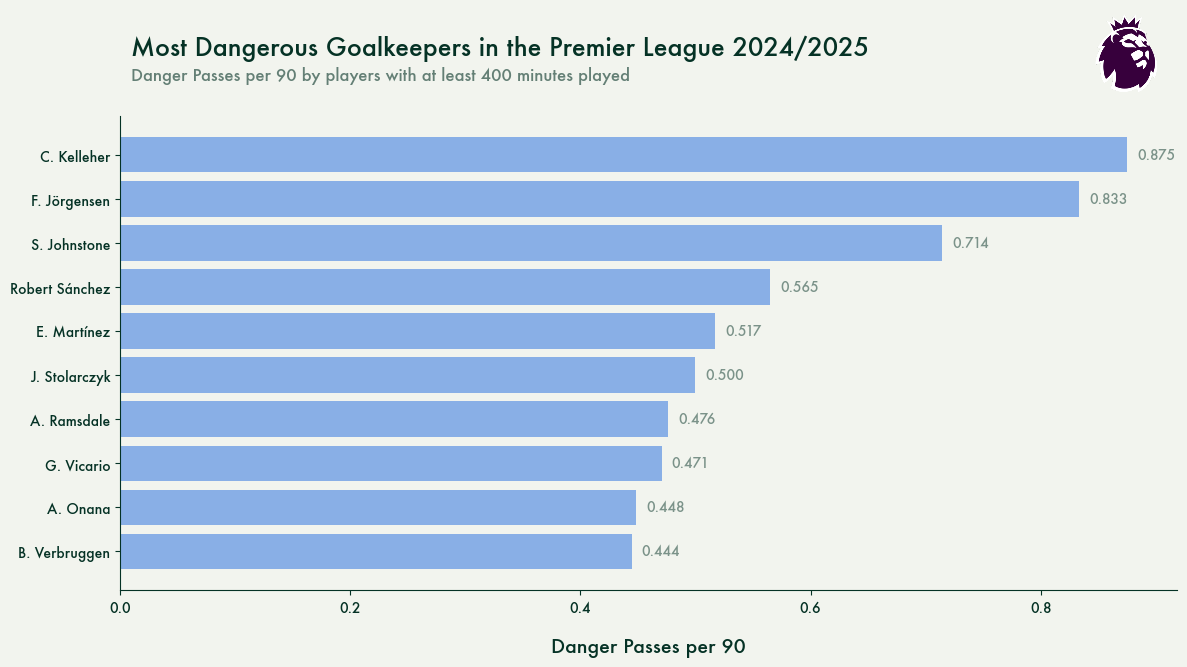

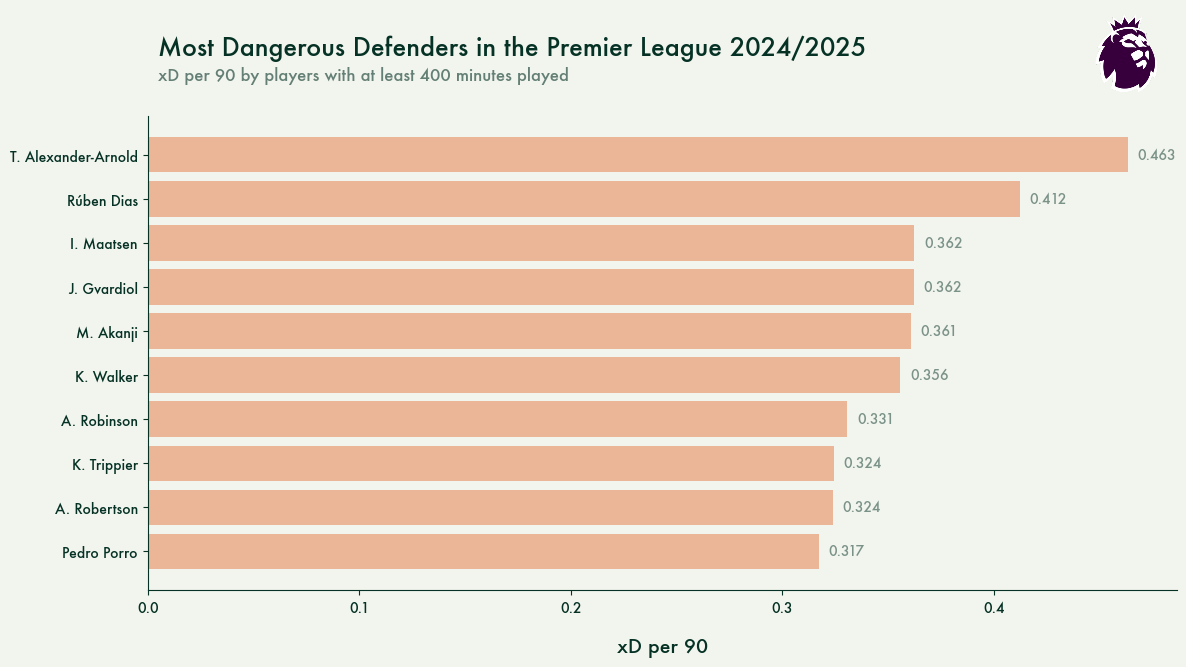

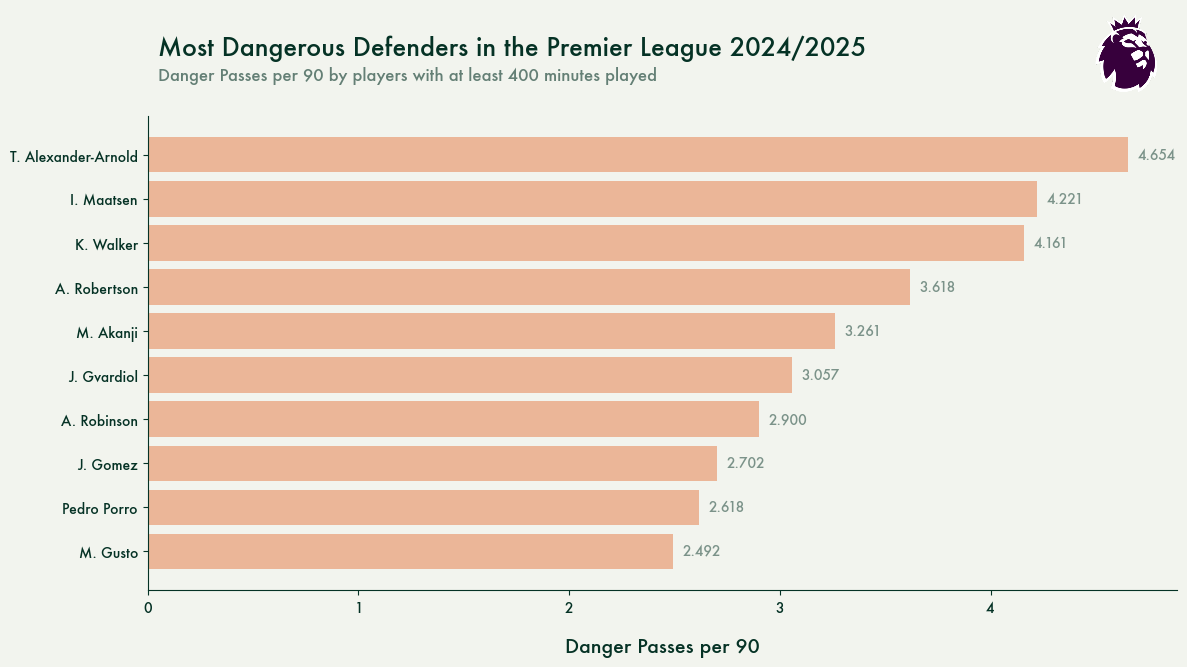

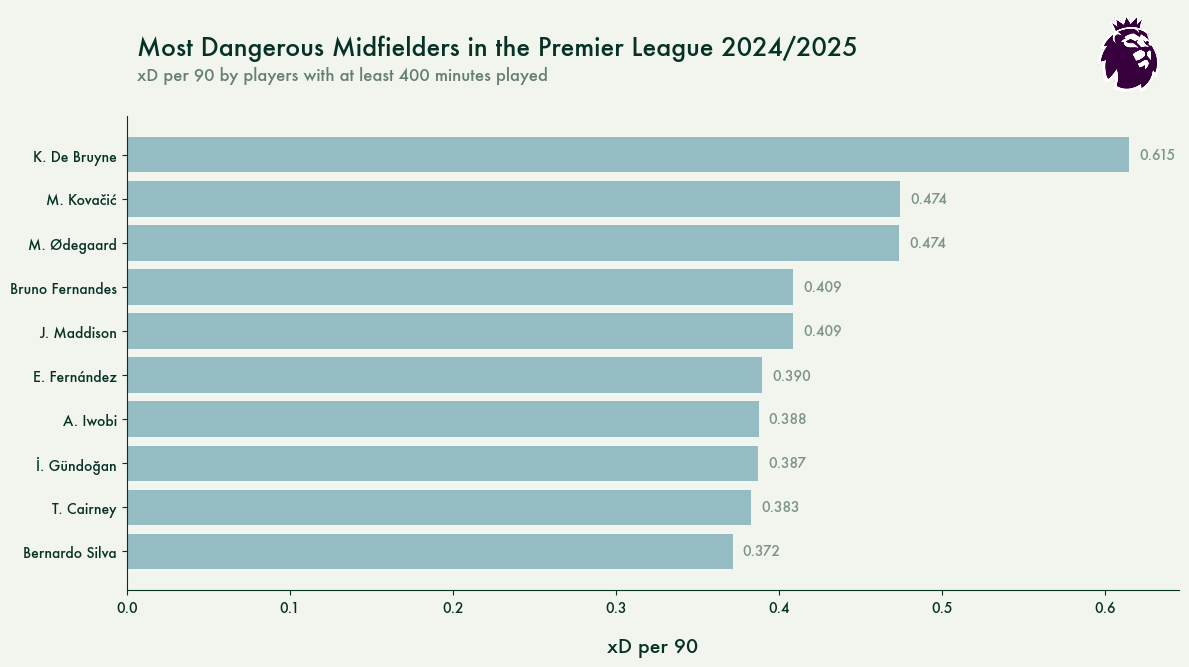

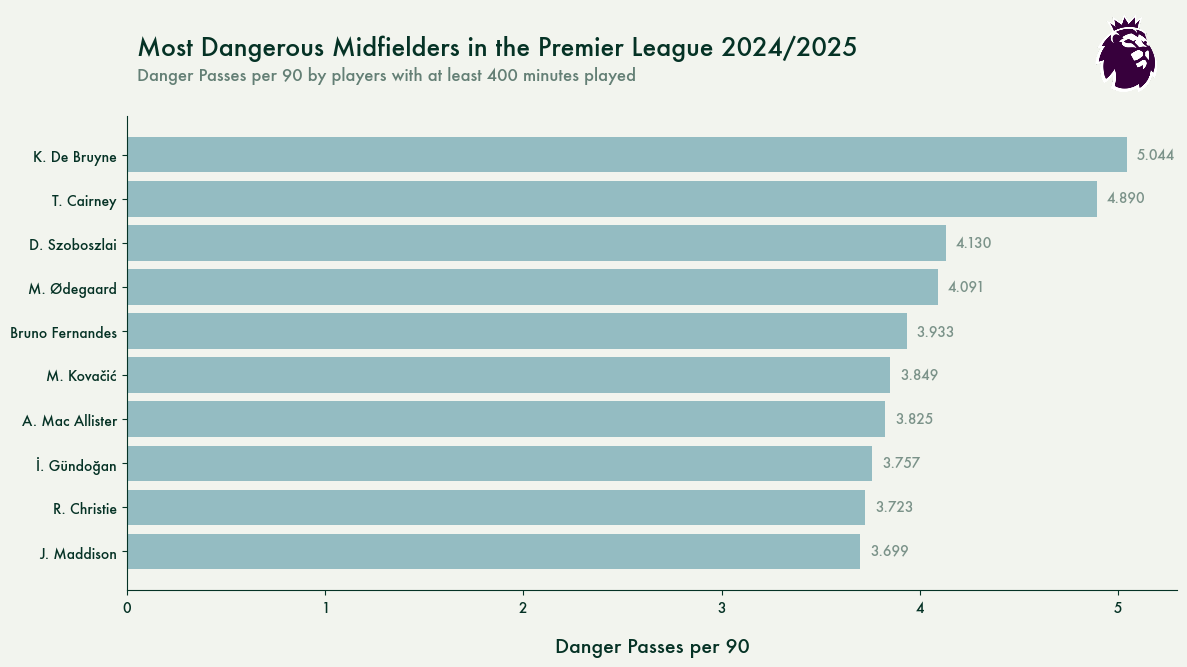

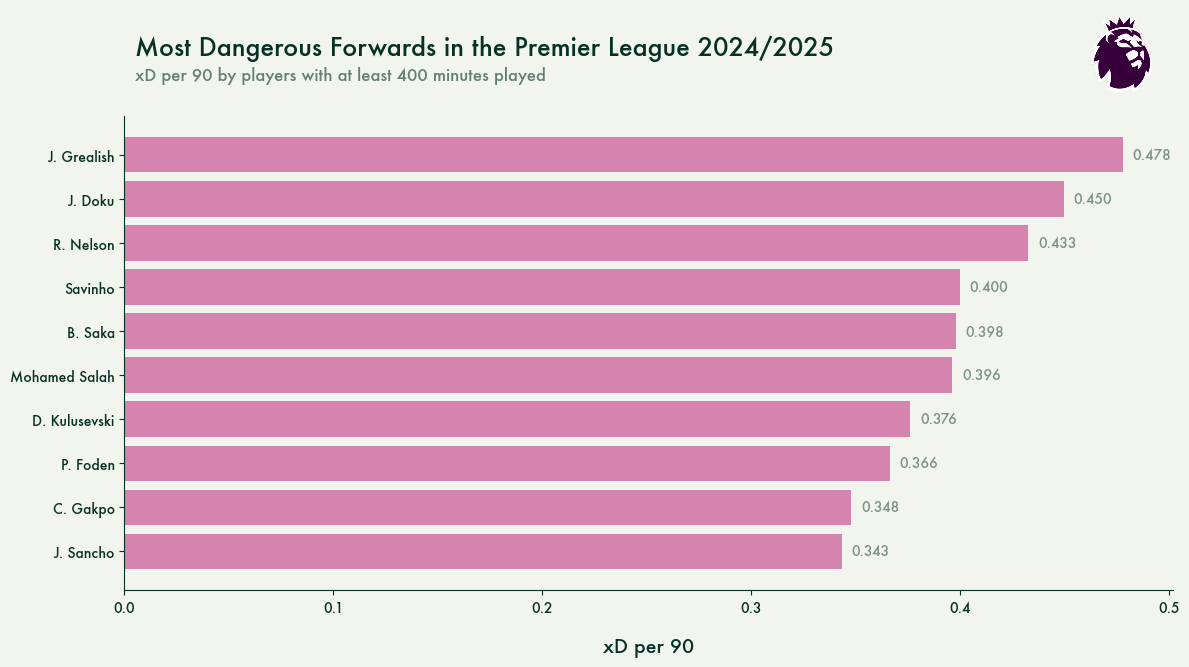

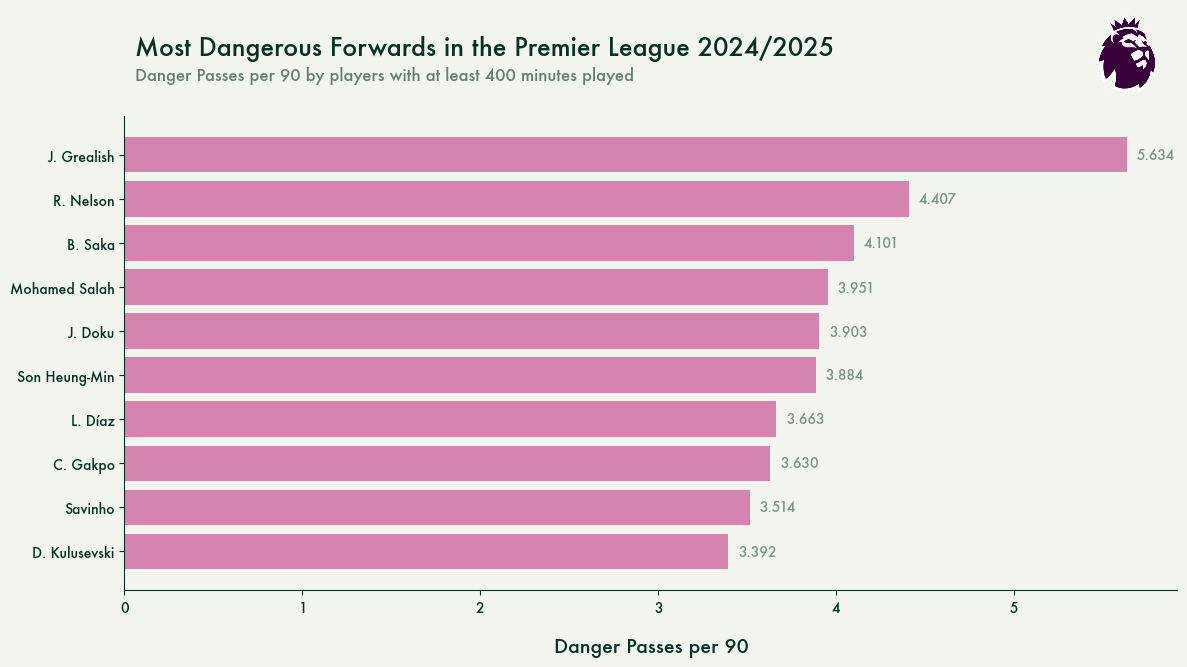

In [54]:
for role in ["Goalkeeper", "Defender", "Midfielder", "Forward"]:
    for metric in ["xD_per_90", "danger_passes_per_90"]:
        ranking = data[data["role"] == role].sort_values(by=metric, ascending=False).head(10).reset_index(drop=True)
        print("--------------------------------")
        print(f"Top 10 {metric} for {role}")
        print("--------------------------------")
        fig = plt.figure(figsize=(12, 1 + 0.6 * len(ranking)))
        gs = fig.add_gridspec(2, 1, height_ratios=[0.1, 0.9])
        fig.set_facecolor(background_color)

        title_ax = fig.add_subplot(gs[0])
        title_ax.axis('off')
        ax = fig.add_subplot(gs[1])
        ax.set_facecolor(background_color)

        plt.rcParams['font.family'] = font
        plt.rcParams.update({
            'text.color': dark_color,
            'axes.labelcolor': dark_color,
            'axes.edgecolor': dark_color,
            'xtick.color': dark_color,
            'ytick.color': dark_color,
            'grid.color': dark_color,
        })

        label = "xD per 90" if metric == "xD_per_90" else "Danger Passes per 90"
        title_ax.text(0.01, 0.8, f"Most Dangerous {role}s in the Premier League 2024/2025", 
                      fontweight='bold', fontsize=18, ha='left', va='center')
        title_ax.text(0.01, 0.3, f'{label} by players with at least 400 minutes played', 
                      fontsize=12, color=dark_color, alpha=0.6, ha='left', va='center')

        logo = mpimg.imread('pl-logo.png')
        imagebox = OffsetImage(logo, zoom=0.25)
        ab = AnnotationBbox(imagebox, (0.98, 0.7), xycoords='axes fraction', box_alignment=(1, 0.5), frameon=False)
        title_ax.add_artist(ab)

        ax.set_xlabel(label, labelpad=15, fontsize=14)

        bar_colors = [role_colors[row['role']] for _, row in ranking.iterrows()]
        ax.barh(ranking['shortName'], ranking[metric], color=bar_colors, alpha=0.5)

        offset = 0.01 * ranking[metric].max()
        for idx, row in ranking.iterrows():
            ax.text(row[metric] + offset, row['shortName'], f"{row[metric]:.3f}", 
                    va='center', ha='left', fontweight='bold', color=dark_color, fontsize=10, alpha=0.5)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.invert_yaxis()

        fig.tight_layout(rect=[0, 0, 1, 0.97])
        plt.savefig(f"rankings/{role.lower()}-{metric.replace('_', '-')}.png", 
                    bbox_inches='tight',
                    pad_inches=0.5,
                    facecolor=background_color,
                    dpi=300)